# Assignment 6: Reinforcement Learning

In [ ]:
!pip install --upgrade pip setuptools

In [ ]:
!apt-get install swig

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 2s (471 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt

In [ ]:
!pip install --no-binary :all: box2d-py

  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=2349116 sha256=970bb8f67bbaf427888ab9e2b7a33a8df89c755ddc101d1ef1dc77e762721098
  Stored in directory: /root/.cache/pip/wheels/47/01/d2/6a780da77ccb98b1d2facdd520a8d10838a03b590f6f8d50c0
Successfully built box2d-py


In [ ]:
!pip install 'gym[box2d]' gym[atari] pyvirtualdisplay

In [ ]:
!pip install gym[classic_control]

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import base64
import glob
from gym.wrappers.record_video import RecordVideo
from IPython.display import HTML, display

1. Create a simple DQN (DQN Agents use Epsilon greedy policy) epsilon policy network with 4 output neurons (one per possible action)

In [ ]:
# Define the neural network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64) # fully connected layer or dense layer that takes state_size inputs and outputs 64 neurons. This is the first hidden layer. the input layer is implied by the input to the first hidden layer (self.fc1)
        self.fc2 = nn.Linear(64, 64) # Second hidden layer: 64 neurons
        self.fc3 = nn.Linear(64, action_size) # Output layer: 4 neurons, one for each possible action.
    # The forward method specifies the activation functions used in the network
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Outputs raw Q-values for each action

# Initialize environment
env = gym.make('LunarLander-v2', new_step_api=True)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n # returns the number of possible actions in the environment, which is 4(four discrete actions: do nothing, fire left orientation engine, fire main engine, or fire right orientation engine.) for LunarLander-v2. This value is assigned to action_size.

# Initialize the networks
policy_net = DQN(state_size, action_size)
target_net = DQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
# Hyperparameters
epsilon = 0.95
epsilon_min = 0.1
epsilon_decay = 0.999
learning_rate = 0.001
batch_size = 64
memory = deque(maxlen=100000) # Initialize replay memory (buffer)

In [ ]:
# Initialize the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

**2. Discuss the rationale of the activation functions & the loss function used in the network.**

**3. Define the hyperparameters: (i) the number of iterations, (ii) the number of episodes, (iii) the maximum number of steps, and (iv) the discount factor  at each step.**

In [ ]:
num_episodes = 1200 # Total episodes to train the agent.
max_steps = 300 # Maximum steps per episode.
gamma = 0.99 # Discount Factor (gamma): Determines the importance of future rewards.
# Iterations: Calculated as num_episodes * max_steps

**4. Train the agent on the LunarLander-v2 environment for a sufficient number of episodes to achieve a satisfactory level of performance (Average reward greater than or equal to 200 is considered a better Agent).**

In [ ]:
# Training involves interacting with the environment, storing experiences, and updating the network:
def train_dqn():
    global epsilon
    episode_rewards = []
    scores_window = deque(maxlen=100)  # last 100 scores
    for episode in range(1, num_episodes + 1):  # Start from 1
        state = env.reset()
        total_reward = 0
        for t in range(max_steps):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    action = policy_net(state_tensor).argmax().item()

            next_state, reward, done, truncated, _ = env.step(action)
            memory.append((state, action, reward, next_state, done or truncated))
            state = next_state
            total_reward += reward

            if done or truncated:
                break

            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.FloatTensor(np.array(states))
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones).unsqueeze(1)

                q_values = policy_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                target_q_values = rewards + (gamma * next_q_values * (1 - dones))

                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        episode_rewards.append(total_reward)
        scores_window.append(total_reward)  # save most recent score

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Print total reward every 10 episodes
        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}")

        # Print average score every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}\tAverage Score: {np.mean(scores_window):.2f}")

        if len(scores_window) >= 100 and np.mean(scores_window) >= 200:
            print(f"\nEnvironment solved in {episode-100} episodes!\tAverage Score: {np.mean(scores_window):.2f}")
            torch.save(policy_net.state_dict(), '/content/drive/My Drive/Centennial College/Unsupervised Learning & Reinforcement Learning/Week 10/checkpoint.pth')
            break

    return episode_rewards

# Train the agent
rewards = train_dqn()

Episode 10, Total Reward: 175.57
Episode 20, Total Reward: 142.60
Episode 30, Total Reward: 155.94
Episode 40, Total Reward: 124.02
Episode 50, Total Reward: -60.36
Episode 60, Total Reward: 115.45
Episode 70, Total Reward: 149.40
Episode 80, Total Reward: 90.62
Episode 90, Total Reward: 154.21
Episode 100, Total Reward: 135.97
Episode 100	Average Score: 120.73
Episode 110, Total Reward: 142.26
Episode 120, Total Reward: 165.23
Episode 130, Total Reward: 112.75
Episode 140, Total Reward: 196.51
Episode 150, Total Reward: 148.12
Episode 160, Total Reward: 182.91
Episode 170, Total Reward: 86.74
Episode 180, Total Reward: 51.93
Episode 190, Total Reward: 141.42
Episode 200, Total Reward: 149.61
Episode 200	Average Score: 127.54
Episode 210, Total Reward: 137.23
Episode 220, Total Reward: 128.47
Episode 230, Total Reward: 166.39
Episode 240, Total Reward: 127.36
Episode 250, Total Reward: -23.61
Episode 260, Total Reward: 153.89
Episode 270, Total Reward: 252.96
Episode 280, Total Reward:

**5. Analyze the agent's learning progress by plotting relevant performance metrics (e.g., cumulative rewards, episode length) over time.**

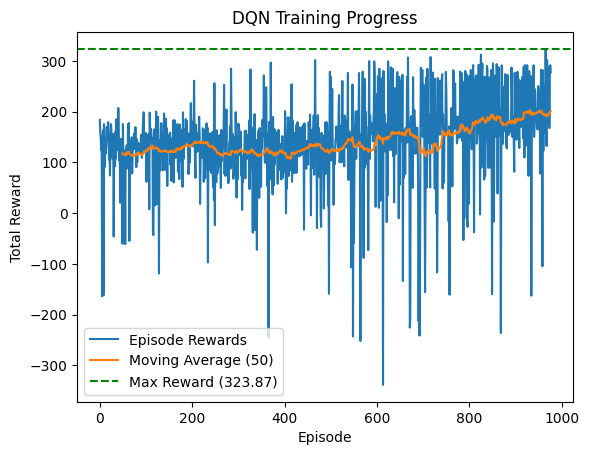

In [ ]:
# Plotting performance metrics:
def plot_metrics(rewards):
    plt.plot(rewards, label="Episode Rewards")
    plt.plot(pd.Series(rewards).rolling(50).mean(), label="Moving Average (50)")
    max_reward = max(rewards)
    plt.axhline(y=max_reward, color='green', linestyle='--', label=f"Max Reward ({max_reward:.2f})")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN Training Progress')
    plt.legend()
    plt.show()

plot_metrics(rewards)

In [ ]:
# Functions to record and display video
def show_video(env_name):
    mp4list = glob.glob('/content/drive/My Drive/Centennial College/Unsupervised Learning & Reinforcement Learning/Week 10/video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]  # Get the first video file
        video = open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(policy_net, env_name):
    env = gym.make(env_name, new_step_api=True, render_mode='rgb_array')
    env = RecordVideo(env, '/content/drive/My Drive/Centennial College/Unsupervised Learning & Reinforcement Learning/Week 10/video', episode_trigger=lambda x: True)
    policy_net.load_state_dict(torch.load('/content/drive/My Drive/Centennial College/Unsupervised Learning & Reinforcement Learning/Week 10/checkpoint.pth', weights_only=True))
    state = env.reset()
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action = policy_net(state_tensor).argmax().item()
        state, reward, done, info = env.step(action)
        if done:
            break
    env.close()


In [ ]:
# Record and display the video
show_video_of_model(policy_net, 'LunarLander-v2')
show_video('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/My Drive/Centennial College/Unsupervised Learning & Reinforcement Learning/Week 10/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


**6. Discuss the challenges faced during training and potential strategies for further improving the agent's performance.**